## REST API

We start by fetching the relevant data.

In [26]:
import requests
import pandas as pd

# Base URL and Endpoint
BASE_URL = "https://api.nobelprize.org/2.1/nobelPrizes"

# Define parameters for the query
params = {
    "nobelPrizeYear": 2022,  # Fetch data for 2022
    "format": "json",        # Specify output format as JSON
    "limit": 100,            # Number of results to return
    "sort": "asc"            # Sort results by year ascending
}

# Make the API request
response = requests.get(BASE_URL, params=params)

# Check response status
if response.status_code == 200:
    # Parse JSON response
    data = response.json()
    
    # Extract relevant fields into a structured format
    prizes = []
    for prize in data.get("nobelPrizes", []):
        category = prize.get("category", {}).get("en", "Unknown")
        year = prize.get("awardYear", "Unknown")
        for laureate in prize.get("laureates", []):
            prizes.append({
                "Year": year,
                "Category": category,
                "Full Name": laureate.get("fullName", {}).get("en", "Unknown"),
                "Motivation": laureate.get("motivation", {}).get("en", "No motivation provided"),
                "Prize Amount": laureate.get("prizeAmount", "Unknown")
            })
    
else:
    print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")

prizes

[{'Year': '2022',
  'Category': 'Chemistry',
  'Full Name': 'Carolyn R. Bertozzi',
  'Motivation': 'for the development of click chemistry and bioorthogonal chemistry',
  'Prize Amount': 'Unknown'},
 {'Year': '2022',
  'Category': 'Chemistry',
  'Full Name': 'Morten Meldal',
  'Motivation': 'for the development of click chemistry and bioorthogonal chemistry',
  'Prize Amount': 'Unknown'},
 {'Year': '2022',
  'Category': 'Chemistry',
  'Full Name': 'K. Barry Sharpless',
  'Motivation': 'for the development of click chemistry and bioorthogonal chemistry',
  'Prize Amount': 'Unknown'},
 {'Year': '2022',
  'Category': 'Economic Sciences',
  'Full Name': 'Ben S. Bernanke',
  'Motivation': 'for research on banks and financial crises',
  'Prize Amount': 'Unknown'},
 {'Year': '2022',
  'Category': 'Economic Sciences',
  'Full Name': 'Douglas W. Diamond',
  'Motivation': 'for research on banks and financial crises',
  'Prize Amount': 'Unknown'},
 {'Year': '2022',
  'Category': 'Economic Science

Now we extract the prize motivations and visualise them in a word cloud.

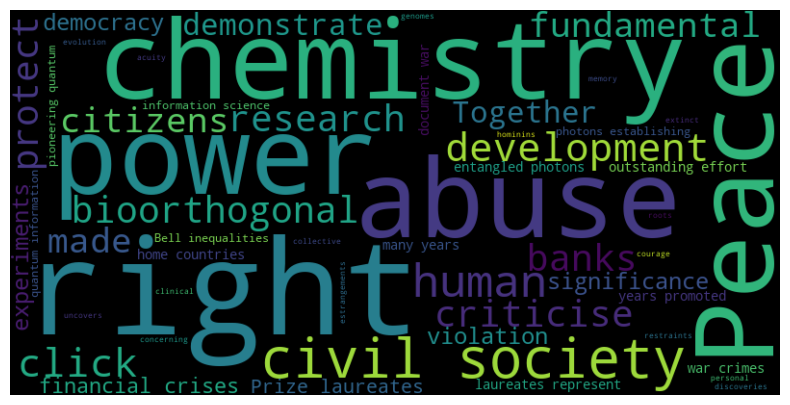

In [27]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

mot = ""

for prize in prizes:
    mot += prize['Motivation'] + " "  # Add a space after each motivation for readability

mot = re.sub(r'[^\w\s]', '', mot)

# Create a WordCloud object
wordcloud = WordCloud(
    width=800,        # Width of the canvas
    height=400,       # Height of the canvas
    background_color='Black',  # Background color
    colormap='viridis',  # Color map
    max_words=100,    # Maximum number of words
    contour_width=1,  # Outline width
    contour_color='steelblue'  # Outline color
).generate(mot)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()


## Web Scraping

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_books(base_url):
    books = []
    page = 1
    while True and page<4:
        url = f"{base_url}/page-{page}.html"
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        
        if response.status_code != 200:
            print(f"Failed to access {url}. Stopping scraper.")
            break
        
        soup = BeautifulSoup(response.text, "html.parser")
        book_items = soup.select("article.product_pod")
        
        if not book_items:
            print("No more pages to scrape.")
            break
        
        for book in book_items:
            # Extracting Title, Price, and Rating from main page
            title = book.h3.a["title"]
            price = book.select_one("p.price_color").text.replace("Â", "")
            rating_class = book.select_one("p.star-rating")["class"]
            rating = rating_class[1]
            
            # Extracting the individual book link
            relative_link = book.h3.a["href"]
            link = base_url + "/" + relative_link
            
            # Visit the individual book page to get the UPC
            book_response = requests.get(link, headers={"User-Agent": "Mozilla/5.0"})
            book_soup = BeautifulSoup(book_response.text, "html.parser")
            upc = book_soup.select_one("table.table.table-striped tr:nth-child(1) td").text
            
            # Append all data to the list
            books.append({
                "Title": title,
                "Price": price,
                "Rating": rating,
                "UPC": upc,
            })
        
        print(f"Scraped page {page} successfully.")
        page += 1  # Move to the next page

    return books

# Base URL for the scraper
base_url = "https://books.toscrape.com/catalogue"
books_data = scrape_books(base_url)

# Convert to DataFrame and display
df = pd.DataFrame(books_data)

Scraped page 1 successfully.
Scraped page 2 successfully.
Scraped page 3 successfully.


The scraper extracts the price, title and rating from the main page and then fetches the upc number from the individual page.

In [29]:
df.head()

,Title,Price,Rating,UPC
0,A Light in the Attic,£51.77,Three,a897fe39b1053632
1,Tipping the Velvet,£53.74,One,90fa61229261140a
2,Soumission,£50.10,One,6957f44c3847a760
3,Sharp Objects,£47.82,Four,e00eb4fd7b871a48
4,Sapiens: A Brief History of Humankind,£54.23,Five,4165285e1663650f
